# Regresión: Optimizar y guardar modelos

En el cuaderno anterior, utilizamos modelos de regresión complejos para analizar la relación entre las características de un conjunto de datos de alquiler de bicicletas. En este cuaderno, veremos si podemos mejorar aún más el rendimiento de estos modelos.

Empecemos cargando los datos de alquiler de bicicletas como un **Pandas** DataFrame y visualizando las primeras filas. Como de costumbre, también dividiremos nuestros datos en conjuntos de datos de entrenamiento y de prueba.

In [1]:
# Import modules we'll need for this notebook
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# load the training dataset
!wget https://raw.githubusercontent.com/MicrosoftDocs/mslearn-introduction-to-machine-learning/main/Data/ml-basics/daily-bike-share.csv
bike_data = pd.read_csv('daily-bike-share.csv')
bike_data['day'] = pd.DatetimeIndex(bike_data['dteday']).day
numeric_features = ['temp', 'atemp', 'hum', 'windspeed']
categorical_features = ['season','mnth','holiday','weekday','workingday','weathersit', 'day']
bike_data[numeric_features + ['rentals']].describe()
print(bike_data.head())


# Separate features and labels
# After separating the dataset, we now have numpy arrays named **X** containing the features, and **y** containing the labels.
X, y = bike_data[['season','mnth', 'holiday','weekday','workingday','weathersit','temp', 'atemp', 'hum', 'windspeed']].values, bike_data['rentals'].values

# Split data 70%-30% into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

print ('Training Set: %d rows\nTest Set: %d rows' % (X_train.shape[0], X_test.shape[0]))


--2024-02-16 14:53:06--  https://raw.githubusercontent.com/MicrosoftDocs/mslearn-introduction-to-machine-learning/main/Data/ml-basics/daily-bike-share.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 48800 (48K) [text/plain]
Saving to: ‘daily-bike-share.csv.1’

daily-bike-share.cs 100%[===================>]  47.66K   195KB/s    in 0.2s    

2024-02-16 14:53:06 (195 KB/s) - ‘daily-bike-share.csv.1’ saved [48800/48800]

   instant    dteday  season  yr  mnth  holiday  weekday  workingday  \
0        1  1/1/2011       1   0     1        0        6           0   
1        2  1/2/2011       1   0     1        0        0           0   
2        3  1/3/2011       1   0     1        0        1           1   
3        4  1/4/2011       1   0     1        0        

Ahora tenemos los siguientes cuatro conjuntos de datos:

- **X_train**: Los valores de la característica que utilizaremos para entrenar el modelo
- **y_train**: Las etiquetas correspondientes que utilizaremos para entrenar el modelo
- **X_test**: Los valores de la característica que utilizaremos para validar el modelo
- **y_test**: Las etiquetas correspondientes que utilizaremos para validar el modelo

Ahora estamos listos para entrenar un modelo ajustando un algoritmo de conjunto *boosting*, como en nuestro último cuaderno. Recuerde que un estimador Gradient Boosting es como un algoritmo Random Forest, pero en lugar de construir todos los árboles de forma independiente y tomar el resultado promedio, cada árbol se basa en las salidas del anterior en un intento de reducir incrementalmente la *pérdida* (error) en el modelo.

GradientBoostingRegressor() 

MSE: 103731.60879754751
RMSE: 322.0739182199445
R2: 0.7966406915260363


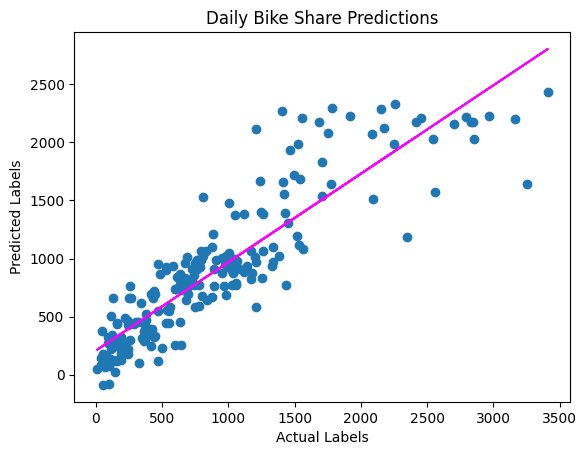

In [2]:
# Train the model
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor


# Fit a lasso model on the training set
model = GradientBoostingRegressor().fit(X_train, y_train)
print (model, "\n")

# Evaluate the model using the test data
predictions = model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
print("MSE:", mse)
rmse = np.sqrt(mse)
print("RMSE:", rmse)
r2 = r2_score(y_test, predictions)
print("R2:", r2)

# Plot predicted vs actual
plt.scatter(y_test, predictions)
plt.xlabel('Actual Labels')
plt.ylabel('Predicted Labels')
plt.title('Daily Bike Share Predictions')
# overlay the regression line
z = np.polyfit(y_test, predictions, 1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test), color='magenta')
plt.show()

## Optimizar Hiperparámetros

Eche un vistazo a la definición del estimador **GradientBoostingRegressor** en la salida anterior y observe que, al igual que los otros estimadores que probamos anteriormente, incluye una gran cantidad de parámetros que controlan la forma en que se entrena el modelo. En el aprendizaje automático, el término *parámetros* se refiere a valores que se pueden determinar a partir de datos; los valores que se especifican para afectar el comportamiento de un algoritmo de entrenamiento se denominan más correctamente *hiperparámetros*.

Los hiperparámetros específicos de un estimador varían según el algoritmo que encapsula el estimador. En el caso del estimador **GradientBoostingRegressor**, el algoritmo es un conjunto que combina múltiples árboles de decisión para crear un modelo predictivo general. Puede obtener mas información sobre los hiperparámetros de este estimador en el [Scikit-Learn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html).

No entraremos en los detalles de cada hiperparámetro aquí, pero trabajan juntos para afectar la forma en que el algoritmo entrena un modelo. En muchos casos, los valores predeterminados proporcionados por Scikit-Learn funcionarán bien, pero podría haber alguna ventaja en modificar los hiperparámetros para obtener un mejor rendimiento predictivo o reducir el tiempo de entrenamiento.

Entonces, ¿cómo sabes qué valores de hiperparámetro utilizar? Bueno, en ausencia de una comprensión profunda de cómo funciona el algoritmo subyacente, tendrá que experimentar. Afortunadamente, Scikit-Learn proporciona una forma de *ajustar* hiperparámetros probando múltiples combinaciones y encontranado el mejor resultado para una determinada métrica de rendimiento.

Intentemos utilizar un enfoque *grid search* para probar combinaciones a partir de una cuadrícula de valores posibles para los hiperparámetros **learning_rate** y **n_estimators** del estimador **GradientBoostingRegressor**.

Best parameter combination: {'learning_rate': 0.1, 'n_estimators': 100} 

GradientBoostingRegressor() 

MSE: 104522.49364963763
RMSE: 323.299387023294
R2: 0.7950902114123279


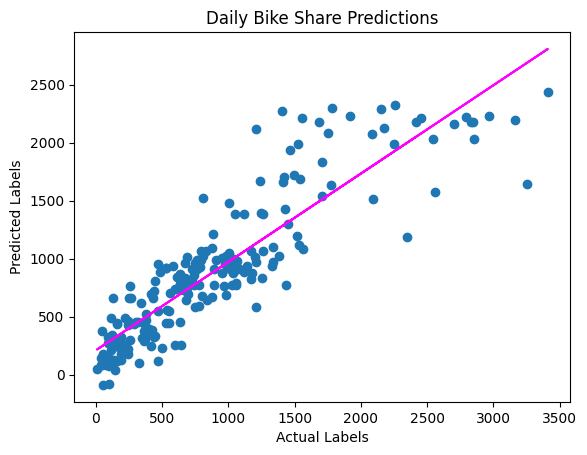

In [3]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, r2_score

# Use a Gradient Boosting algorithm
alg = GradientBoostingRegressor()

# Try these hyperparameter values
params = {
 'learning_rate': [0.1, 0.5, 1.0],
 'n_estimators' : [50, 100, 150]
 }

# Find the best hyperparameter combination to optimize the R2 metric
score = make_scorer(r2_score)
gridsearch = GridSearchCV(alg, params, scoring=score, cv=3, return_train_score=True)
gridsearch.fit(X_train, y_train)
print("Best parameter combination:", gridsearch.best_params_, "\n")

# Get the best model
model=gridsearch.best_estimator_
print(model, "\n")

# Evaluate the model using the test data
predictions = model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
print("MSE:", mse)
rmse = np.sqrt(mse)
print("RMSE:", rmse)
r2 = r2_score(y_test, predictions)
print("R2:", r2)

# Plot predicted vs actual
plt.scatter(y_test, predictions)
plt.xlabel('Actual Labels')
plt.ylabel('Predicted Labels')
plt.title('Daily Bike Share Predictions')
# overlay the regression line
z = np.polyfit(y_test, predictions, 1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test), color='magenta')
plt.show()

> **Nota**: El uso de valores aleatorios en el algoritmo Gradient Boosting da como resultado métricas ligeramente diferentes cada vez. En este caso, es poco probable que el mejor modelo producido por el ajuste de hiperparámetros sea significativamente mejor que uno entrenado con los valores predeterminados de hiperparámetros; ¡pero sigue siendo útil conocer la técnica de ajuste de hiperparámetros!

## Preprocesar los datos

Entrenamos un modelo con datos que cargamos directamente de un archivo fuente, con solo resultados moderadamente satisfactorios.

En la práctica, es habitual preprocesar los datos para facilitar al algoritmo el ajuste del modelo. Hay una gran variedad de transformaciones de preprocesamiento que se pueden realizar para preparar los datos para el modelado, pero nos limitaremos a algunas técnicas comunes:

### Escalado de características numéricas

Normalizar las características numéricas para que estén en la misma escala evita que las características con grandes valores produzcan coeficientes que afectan desproporcionadamente las predicciones. Por ejemplo, suponga que sus datos incluyen las siguientes características numéricas:

| A |  B  |  C  |
| - | --- | --- |
| 3 | 480 | 65  |
    
Normalizar estas características a la misma escala puede dar como resultado los siguientes valores (suponiendo que A contiene valores de 0 a 10, B contiene valores de 0 a 1000, y C contiene valores de 0 a 100):

|  A  |  B  |  C  |
| --  | --- | --- |
| 0.3 | 0.48| 0.65|

Existen múltiples formas de escalar datos numéricos, como calcular los valores mínimos y máximos para cada columna y asignar un valor proporcional entre 0 y 1, o utilizando la media y la desviación estándar de una variable distribuida normalmente para mantener la misma *dispersión* de valores en una escala diferente.

### Codificación de variables categóricas

Los modelos de aprendizaje automático funcionan mejor con características numéricas que con valores de texto, por lo que generalmente es necesario convertir las características categóricas en representaciones numéricas. Por ejemplo, supongamos que sus datos incluyen la siguiente característica categórica:

| Size |
| ---- |
|  S   |
|  M   |
|  L   |

Puede aplicar la *codificación ordinal* para sustituir cada categoría por un valor entero único, de esta forma:

| Size |
| ---- |
|  0   |
|  1   |
|  2   |

Otra técnica habitual es utilizar *codificación one-hot* para crear características binarias (0 o 1) individuales para cada posible valor de categoría. Por ejemplo, puede usar la codificación one-hot para traducir las posibles categorías en columnas binarias como esta:

|  Size_S  |  Size_M  |  Size_L  |
| -------  | -------- | -------- |
|    1     |     0    |    0     |
|    0     |     1    |    0     |
|    0     |     0    |    1     |

Para aplicar estas transformaciones de preprocesamiento al alquiler de bicicletas, haremos uso de una función de Scikit-Learn denominada pipelines. Estas tuberías nos permiten definir un conjunto de pasos de preprocesamiento que terminan con un algoritmo. A continuación, puede ajustar toda la tubería a los datos, de modo que el modelo encapsula todos los pasos de preprocesamiento, así como el algoritmo de regresión. Esto es útil, porque cuando queremos usar el modelo para predecir valores de nuevos datos, necesitamos aplicar las mismas transformaciones (basadas en las mismas distribuciones estadísticas y codificaciones de categoría utilizadas con los datos de entrenamiento).

> **Nota**: El término *pipeline* se utiliza ampliamente en el aprendizaje automático, ¡a menudo para significar cosas muy diferentes! En este contexto, lo estamos utilizando para referirnos a los objetos de pipeline en Scikit-Learn, pero es posible que lo veas en otros sitios para significar otra cosa.

In [4]:
# Train the model
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
import numpy as np

# Define preprocessing for numeric columns (scale them)
numeric_features = [6,7,8,9]
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

# Define preprocessing for categorical features (encode them)
categorical_features = [0,1,2,3,4,5]
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Create preprocessing and training pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', GradientBoostingRegressor())])


# fit the pipeline to train a linear regression model on the training set
model = pipeline.fit(X_train, (y_train))
print (model)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  [6, 7, 8, 9]),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  [0, 1, 2, 3, 4, 5])])),
                ('regressor', GradientBoostingRegressor())])


Ok, el modelo está entrenado, incluidos los pasos de preprocesamiento. Veamos cómo funciona con los datos de validación.

MSE: 104945.44899641888
RMSE: 323.9528499587847
R2: 0.7942610340011815


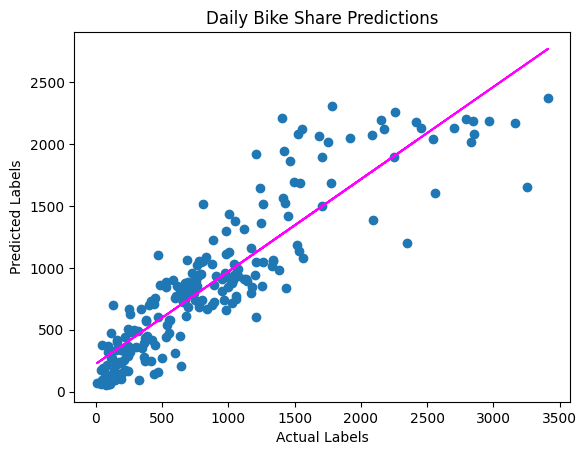

In [5]:
# Get predictions
predictions = model.predict(X_test)

# Display metrics
mse = mean_squared_error(y_test, predictions)
print("MSE:", mse)
rmse = np.sqrt(mse)
print("RMSE:", rmse)
r2 = r2_score(y_test, predictions)
print("R2:", r2)

# Plot predicted vs actual
plt.scatter(y_test, predictions)
plt.xlabel('Actual Labels')
plt.ylabel('Predicted Labels')
plt.title('Daily Bike Share Predictions')
z = np.polyfit(y_test, predictions, 1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test), color='magenta')
plt.show()

El pipeline está compuesto por las transformaciones y el algoritmo utilizado para entrenar el modelo. Para probar un algoritmo alternativo, basta con cambiar ese paso por otro tipo de estimador.

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  [6, 7, 8, 9]),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  [0, 1, 2, 3, 4, 5])])),
                ('regressor', RandomForestRegressor())]) 

MSE: 103338.28523409089
RMSE: 321.4627275969811
R2: 0.7974117776857734


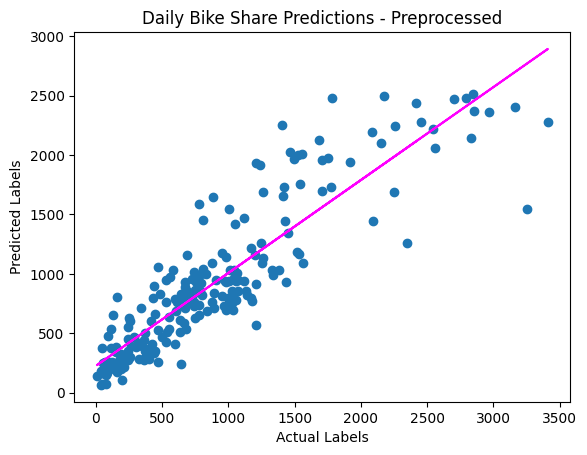

In [6]:
# Use a different estimator in the pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', RandomForestRegressor())])


# fit the pipeline to train a linear regression model on the training set
model = pipeline.fit(X_train, (y_train))
print (model, "\n")

# Get predictions
predictions = model.predict(X_test)

# Display metrics
mse = mean_squared_error(y_test, predictions)
print("MSE:", mse)
rmse = np.sqrt(mse)
print("RMSE:", rmse)
r2 = r2_score(y_test, predictions)
print("R2:", r2)

# Plot predicted vs actual
plt.scatter(y_test, predictions)
plt.xlabel('Actual Labels')
plt.ylabel('Predicted Labels')
plt.title('Daily Bike Share Predictions - Preprocessed')
z = np.polyfit(y_test, predictions, 1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test), color='magenta')
plt.show()

Ya hemos visto una serie de técnicas comunes utilizadas para entrenar modelos predictivos de regresión. En un proyecto real, es probable que pruebe algunos algoritmos, hiperparámetros y transformaciones de preprocesamiento; pero a estas alturas ya debería tener una idea general. Exploremos cómo puede utilizar el modelo entrenado con nuevos datos.

### Utilizar el modelo entrenado

En primer lugar, guardemos el modelo.

In [7]:
import joblib

# Save the model as a pickle file
filename = './bike-share.pkl'
joblib.dump(model, filename)

['./bike-share.pkl']

Ahora, podemos cargarlo cuando lo necesitemos y usarlo para predecir las etiquetas para nuevos datos. Esto suele denominarse  *puntuación* o *inferencia*.

In [8]:
# Load the model from the file
loaded_model = joblib.load(filename)

# Create a numpy array containing a new observation (for example tomorrow's seasonal and weather forecast information)
X_new = np.array([[1,1,0,3,1,1,0.226957,0.22927,0.436957,0.1869]]).astype('float64')
print ('New sample: {}'.format(list(X_new[0])))

# Use the model to predict tomorrow's rentals
result = loaded_model.predict(X_new)
print('Prediction: {:.0f} rentals'.format(np.round(result[0])))

New sample: [1.0, 1.0, 0.0, 3.0, 1.0, 1.0, 0.226957, 0.22927, 0.436957, 0.1869]
Prediction: 100 rentals


El método **predict** del modelo acepta una matriz de observaciones, por lo que puede utilizarlo para generar múltiples predicciones por lote. Por ejemplo, supongamos que dispone de un pronóstico del tiempo para los próximos cinco días; podría utilizar el modelo para predecir el alquiler de bicicletas para cada día en función de las condiciones meteorológicas previstas.

In [9]:
# An array of features based on five-day weather forecast
X_new = np.array([[0,1,1,0,0,1,0.344167,0.363625,0.805833,0.160446],
                  [0,1,0,1,0,1,0.363478,0.353739,0.696087,0.248539],
                  [0,1,0,2,0,1,0.196364,0.189405,0.437273,0.248309],
                  [0,1,0,3,0,1,0.2,0.212122,0.590435,0.160296],
                  [0,1,0,4,0,1,0.226957,0.22927,0.436957,0.1869]])

# Use the model to predict rentals
results = loaded_model.predict(X_new)
print('5-day rental predictions:')
for prediction in results:
    print(np.round(prediction))

5-day rental predictions:
596.0
701.0
247.0
222.0
279.0


## Resumen

Con esto concluyen los cuadernos de este módulo sobre regresión. En este cuaderno, hemos ejecutado una regresión compleja, la hemos ajustado, hemos guardado el modelo y lo hemos utilizado para predecir resultados futuros.

## Lecturas Adicionales

Para obtener más información sobre Scikit-Learn, consulte [Scikit-Learn documentation](https://scikit-learn.org/stable/user_guide.html).
